In [1]:
from Data.IMDB import IMDB
from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
import dgl
import torch

/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /storage/scratch/0994359/hetero-conv-matching/.venv/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/torch

In [2]:
imdb = IMDB()
original_graph = imdb.load_graph()


In [3]:
device = "cuda:0"
original_graph = original_graph.to(device)
num_nearest_init_neighbors_per_type = {"actortomovie": 10, "directortomovie": 10, "movietoactor":10, "movietodirector":10, "actor":10, "director":10, "movie":10}

coarsener = HeteroRGCNCoarsener(original_graph, 0.4, num_nearest_init_neighbors_per_type, device=device, use_cca=True, pairs_per_level=10,norm_p=1, approx_neigh=True, add_feat=False, use_out_degree=False) 

coarsener.init()

/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


actortomovie
directortomovie
movietoactor
movietodirector
actor
director
movie


In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [23]:
for i in range(30):
    print(i)
    coarsener.coarsen_step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [26]:
import torch
coarsend_graph = coarsener.summarized_graph

#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("movie")
labels = coarsener.get_labels(mapping, "movie")
coarsener.make_mask(mapping, "movie")
coarsend_graph.nodes["movie"].data["label"] = torch.tensor([labels[i] for i in range(len(labels)) ],  device=device) #,
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


ratio 0.1322314049586777


In [27]:
print(original_graph.nodes["movie"].data["train_mask"].sum())
print(original_graph.nodes["movie"].data["test_mask"].sum())

print(coarsend_graph.nodes["movie"].data["train_mask"].sum())
print(coarsend_graph.nodes["movie"].data["test_mask"].sum())

tensor(400, device='cuda:0')
tensor(3478, device='cuda:0')
tensor(108, device='cuda:0')
tensor(810, device='cuda:0')


In [28]:
import torch
import dgl
from torch_geometric.data import Data
from torch_geometric.data import HeteroData
def from_dgl_hetero_manual(g: dgl.DGLHeteroGraph) -> HeteroData:
    """
    Convert a DGL heterogeneous graph into a PyG HeteroData object.

    Args:
        g (dgl.DGLHeteroGraph): Input DGL heterogeneous graph with node/edge features stored in ndata/edata.

    Returns:
        HeteroData: A PyG HeteroData object with the same node and edge features.
    """
    data = HeteroData()

    # Convert node features for each node type
    for ntype in g.ntypes:
        # Collect all feature fields for this node type
        ndata = g.nodes[ntype].data
        # If there is a 'feat' entry, map it to .x in PyG
        if 'feat' in ndata:
            data[ntype].feat = ndata['feat']
        # Map any other node data fields directly
        for key, value in ndata.items():
            if key != 'feat':
                data[ntype][key] = value

    # Convert edges for each canonical edge type
    for c_etype in g.canonical_etypes:
        src_type, etype, dst_type = c_etype
        # Get edge index (source, target)
        src_nodes, dst_nodes = g.edges(etype=c_etype)
        edge_index = torch.stack([src_nodes, dst_nodes], dim=0)
        # Assign edge_index
        data[c_etype].edge_index = edge_index

        # Collect edge features
        edata = g.edges[c_etype].data
        # If there is a 'feat' entry, map it to .edge_attr
        if 'feat' in edata:
            data[c_etype].edge_attr = edata['feat']
        # Map any other edge data fields directly
        for key, value in edata.items():
            if key != 'feat':
                data[c_etype][key] = value

    return data

def dgl_to_pyg_input(g):
    # Convert DGL heterograph to PyG's HeteroData
    pyg_data = from_dgl_hetero_manual  (g)

    x_dict = {}
    for ntype in g.ntypes:
        if 'feat' in g.nodes[ntype].data:
            x_dict[ntype] = g.nodes[ntype].data['feat'].to(device)

    edge_index_dict = {}
    for canonical_etype in g.canonical_etypes:
        src_type, rel_type, dst_type = canonical_etype
        src, dst = g.edges(etype=canonical_etype)
        edge_index = torch.stack([src, dst], dim=0)
        edge_index_dict[(src_type, rel_type, dst_type)] = edge_index.to(device)
    pyg_data.edge_index_dict = edge_index_dict
    return pyg_data,x_dict, edge_index_dict, g.ntypes, g.canonical_etypes


In [33]:
coarsened_data

HeteroData(
  edge_index_dict={
    (actor, actortomovie, movie)=[2, 1922],
    (director, directortomovie, movie)=[2, 1119],
    (movie, movietoactor, actor)=[2, 1922],
    (movie, movietodirector, director)=[2, 1119],
  },
  actor={
    feat=[217, 30],
    node_size=[217],
    deg_actortomovie=[217],
    deg_movietoactor=[217],
    sactortomovie=[217, 30],
    hactortomovie=[217, 30],
    iactortomovie=[217],
  },
  director={
    feat=[401, 30],
    node_size=[401],
    deg_directortomovie=[401],
    deg_movietodirector=[401],
    sdirectortomovie=[401, 30],
    hdirectortomovie=[401, 30],
    idirectortomovie=[401],
  },
  movie={
    feat=[918, 30],
    label=[918],
    train_mask=[918],
    val_mask=[918],
    test_mask=[918],
    node_size=[918],
    deg_actortomovie=[918],
    deg_directortomovie=[918],
    deg_movietoactor=[918],
    deg_movietodirector=[918],
    imovietoactor=[918],
    imovietodirector=[918],
    smovietoactor=[918, 30],
    hmovietoactor=[918, 30],
    smo

In [29]:
original_data, o_x_dict, o_edge_index_dict, o_node_types, o_edge_types = dgl_to_pyg_input(original_graph)
coarsened_data, c_x_dict, c_edge_index_dict, c_node_types, c_edge_types = dgl_to_pyg_input(coarsend_graph)

In [30]:
from torch_geometric.nn import HeteroConv, SAGEConv

class ImprovedHeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, x_dict,num_classes, target_feat="author", num_layers=2, dropout=0.3, with_non_linear = True):
        
        super().__init__()
        self.target_feat = target_feat
        # Extract node types and edge types from metadata
        node_types, edge_types = metadata[0], metadata[1]
        
        # Create embedding layers for each node type with proper dimensions
        self.embeddings = torch.nn.ModuleDict()
        for node_type, feat_dim in { i: x_dict[i].size(1) for i in  x_dict.keys()}.items():
            self.embeddings[node_type] = torch.nn.Linear(feat_dim, hidden_channels)
        
        # Multiple heterogeneous conv layers for message passing
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv_dict = {}
            for edge_type in edge_types:
                # Use the proper dimensions for source and target nodes
                conv_dict[edge_type] = SAGEConv(
                    hidden_channels, 
                    hidden_channels, 
                 #   add_self_loops=False,
                    normalize=True
                )
            self.convs.append(HeteroConv(conv_dict, aggr='mean'))
        
        # Layer normalization for each node type
        self.layer_norms = torch.nn.ModuleDict({
            node_type: torch.nn.LayerNorm(hidden_channels)
            for node_type in node_types
        })
        if with_non_linear:
            # Output projection layers
            self.output_projs = torch.nn.ModuleDict({
                node_type: torch.nn.Sequential(
                    torch.nn.Linear(hidden_channels, hidden_channels),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(dropout),
                    torch.nn.Linear(hidden_channels, num_classes if node_type == target_feat else hidden_channels)
                )
                for node_type in node_types
            })
        else:
            # Output projection layers
            self.output_projs = torch.nn.ModuleDict({
                node_type: torch.nn.Sequential(
                    torch.nn.Linear(hidden_channels, hidden_channels),
                    torch.nn.Dropout(dropout),
                    torch.nn.Linear(hidden_channels, num_classes if node_type == target_feat else hidden_channels)
                )
                for node_type in node_types
            })
                
        self.dropout = dropout
        
    def forward(self, x_dict, edge_index_dict):
        # Initial embedding of node features
        x_dict = {node_type: self.embeddings[node_type](x) 
                 for node_type, x in x_dict.items()}
        
        # Apply multiple layers of heterogeneous graph convolutions
        for conv in self.convs:
            # Store previous embeddings for residual connections
            x_dict_prev = {k: v.clone() for k, v in x_dict.items()}
            
            # Apply heterogeneous convolution
            x_dict = conv(x_dict, edge_index_dict)
            
            # Apply layer normalization, non-linearity, dropout and residual connection
            x_dict = {
                node_type: self.layer_norms[node_type](
                    F.relu(x) + x_dict_prev[node_type]  # Residual connection
                )
                for node_type, x in x_dict.items()
            }
            
            # Apply dropout to intermediate representations
            x_dict = {
                node_type: F.dropout(x, p=self.dropout, training=self.training)
                for node_type, x in x_dict.items()
            }
        
        # Final projection for each node type
        output_dict = {
            node_type: self.output_projs[node_type](x)
            for node_type, x in x_dict.items()
        }
        
        # Apply log softmax to author nodes (for classification)
        if self.target_feat in output_dict:
            output_dict[self.target_feat] = F.log_softmax(output_dict[self.target_feat], dim=1)
            
        return output_dict


In [31]:
original_data = original_data.to(device)
coarsened_data =coarsened_data.to(device) 

Epoch 1:
  Original Graph - Loss: 1.0947, Accuracy: 0.3643
  Coarsened Graph - Loss: 1.1118, Accuracy: 0.3444
  Inverted Coarsened - Accuracy: 0.3471

Epoch 11:
  Original Graph - Loss: 1.0853, Accuracy: 0.3643
  Coarsened Graph - Loss: 1.0960, Accuracy: 0.3716
  Inverted Coarsened - Accuracy: 0.3612

Epoch 21:
  Original Graph - Loss: 1.0764, Accuracy: 0.3634
  Coarsened Graph - Loss: 1.0786, Accuracy: 0.3753
  Inverted Coarsened - Accuracy: 0.3644

Epoch 31:
  Original Graph - Loss: 1.0746, Accuracy: 0.3606
  Coarsened Graph - Loss: 1.0761, Accuracy: 0.3753
  Inverted Coarsened - Accuracy: 0.3644

Epoch 41:
  Original Graph - Loss: 1.0778, Accuracy: 0.3657
  Coarsened Graph - Loss: 1.0703, Accuracy: 0.3753
  Inverted Coarsened - Accuracy: 0.3644

Epoch 51:
  Original Graph - Loss: 1.0870, Accuracy: 0.3649
  Coarsened Graph - Loss: 1.0759, Accuracy: 0.3753
  Inverted Coarsened - Accuracy: 0.3644

Epoch 61:
  Original Graph - Loss: 1.0832, Accuracy: 0.3652
  Coarsened Graph - Loss: 1.0

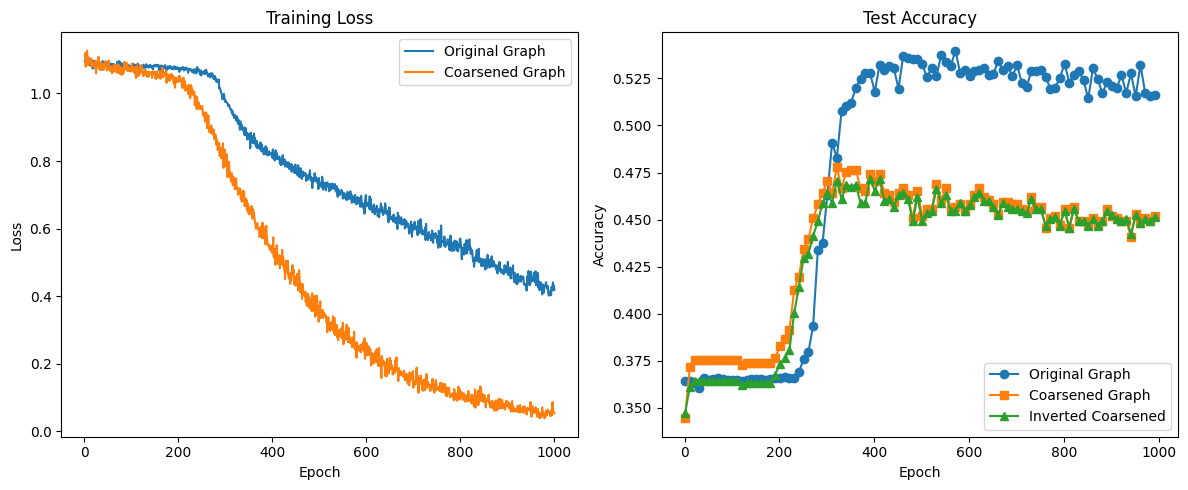

Final Performance Comparison:
Original Graph Accuracy: 0.5161
Coarsened Graph Accuracy: 0.4519
Inverted Coarsened Accuracy: 0.4512


In [38]:
# Import necessary libraries (if not already imported)
import torch
import torch.nn.functional as F
import numpy as np
#from Models.GNNs.HGCN import ImprovedHeteroGNN


original_x_dict = o_x_dict
coarsened_x_dict = c_x_dict
o_metadata = (o_node_types, o_edge_types)
c_metadata=(c_node_types, c_edge_types)
#original_x_dict.update({"conference": torch.zeros((original_data["conference"]["num_nodes"], 1))})# = 0  #= 0#
#coarsened_x_dict.update({"conference": torch.zeros((coarsened_data["conference"]["num_nodes"], 1))})# = 0  #= 0#

#num_classes = len(original_data["author"]["label"].unique())

target_node_type = "movie"
# Your existing model definition
model_original = ImprovedHeteroGNN(metadata=o_metadata,target_feat=target_node_type, x_dict= original_x_dict ,num_classes= 3, dropout=0.1, hidden_channels=64, with_non_linear= True)
model_coarsened = ImprovedHeteroGNN(metadata=c_metadata, target_feat=target_node_type,x_dict= coarsened_x_dict,num_classes= 3, dropout=0.1,hidden_channels=64, with_non_linear= True)
model_original = model_original.to(device)
model_coarsened = model_coarsened.to(device)
# Optimizers
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.0001, weight_decay=5e-4) # weight_decay=5e-4
optimizer_coarsened = torch.optim.Adam(model_coarsened.parameters(), lr=0.0001, weight_decay=5e-4) #


# Function to apply inversion mapping from coarsened to original
def apply_inversion_mapping(coarsened_pred, inversion_map, original_labels, test_mask):
    """
    Maps predictions from coarsened graph back to original graph nodes
    
    Args:
        coarsened_pred: Predictions on coarsened graph
        inversion_map: Mapping from coarsened nodes to original nodes
        original_labels: Ground truth labels of original graph
        
    Returns:
        mapped_accuracy: Accuracy after applying inversion mapping
    """
    correct_count = 0
    total_count = 0
    
    for orig_node, coarsened_node in inversion_map.items():
        if not test_mask[coarsened_node]:
            continue
        coarse_pred = coarsened_pred[coarsened_node]
        orig_label = original_labels[orig_node]
        #print(coarse_pred, orig_label)

        correct = (coarse_pred == orig_label)
    
                
        if correct:
            correct_count += 1
     #   else:
      #      print(f"Mismatch: Coarsened Node {coarsened_node} predicted {coarse_pred}, Original Node {orig_node} label {orig_label}")
        total_count += 1
    
    return correct_count / total_count if total_count > 0 else 0
def apply_inversion_mapping_new(coarsened_pred, inversion_map, original_labels, test_mask):
    correct_count = 0
    total_count = 0
    for orig_node, coarsened_node in inversion_map.items():
        if coarsened_node not in test_mask:
            continue
        coarse_pred = coarsened_pred[coarsened_node]
        orig_label = original_labels[orig_node]
        if coarse_pred == orig_label:
            correct_count += 1
        total_count += 1
    return correct_count / total_count if total_count > 0 else 0
# Training function for original graph
def train_original():
    model_original.train()
    optimizer_original.zero_grad()
    
    #print(original_x_original_data.edge_index_dict)
    out = model_original(original_x_dict, original_data.edge_index_dict)
    loss = F.nll_loss(
        out[target_node_type][original_data[target_node_type].train_mask], 
        original_data[target_node_type]["label"][original_data[target_node_type].train_mask]
    )
    loss.backward()
    optimizer_original.step()
    return loss.item()

# Training function for coarsened graph
def train_coarsened():
    model_coarsened.train()
    optimizer_coarsened.zero_grad()
    out = model_coarsened(coarsened_x_dict, coarsened_data.edge_index_dict)
    loss = F.nll_loss(
        out[target_node_type][coarsened_data[target_node_type].train_mask], 
        coarsened_data[target_node_type]["label"][coarsened_data[target_node_type].train_mask]
    )
    loss.backward()
    optimizer_coarsened.step()
    return loss.item()

# Evaluation function for original graph
def test_original():
    model_original.eval()
    with torch.no_grad():
        out = model_original(original_x_dict, original_data.edge_index_dict)
        pred = out[target_node_type].argmax(dim=1)
        
        # Calculate accuracy on test set
        correct = pred[original_data[target_node_type].test_mask] == original_data[target_node_type]["label"][original_data[target_node_type].test_mask]
        acc = int(correct.sum()) / int(original_data[target_node_type].test_mask.sum())
        return acc

# Evaluation function for coarsened graph
def test_coarsened():
    model_coarsened.eval()
    with torch.no_grad():
        out = model_coarsened(coarsened_x_dict, coarsened_data.edge_index_dict)
        pred = out[target_node_type].argmax(dim=1)
        
        # Calculate accuracy on test set
        coarsened_acc = int(
            (pred[coarsened_data[target_node_type].test_mask] == 
             coarsened_data[target_node_type]["label"][coarsened_data[target_node_type].test_mask]).sum()
        ) / int(coarsened_data[target_node_type].test_mask.sum())
        inverted_acc = 0
        out = model_coarsened(coarsened_x_dict, coarsened_data.edge_index_dict)
        pred = out[target_node_type].argmax(dim=1)
        
        #Apply inversion mapping to evaluate how coarsened predictions map to original graph
        inverted_acc  = apply_inversion_mapping(
             pred,  
             mapping,
             original_data[target_node_type]["label"], 
             coarsened_data[target_node_type].test_mask
         )
        return coarsened_acc, inverted_acc

# Training for 50 epochs and comparing both models
results = {
    "epoch": [],
    "original_loss": [],
    "coarsened_loss": [],
    "original_acc": [],
    "coarsened_acc": [],
    "inverted_acc": []
}
epochs = 1000
for epoch in range(epochs):
    # Train both models
    original_loss = train_original()
    coarsened_loss = train_coarsened()
    
    # Store results
    results["epoch"].append(epoch+1)
    results["original_loss"].append(original_loss)
    results["coarsened_loss"].append(coarsened_loss)
    
    # Evaluate every 10 epochs
    if epoch % 10 == 0:
        original_acc = test_original()
        coarsened_acc, inverted_acc = test_coarsened()
        
        results["original_acc"].append(original_acc)
        results["coarsened_acc"].append(coarsened_acc)
        results["inverted_acc"].append(inverted_acc)
        
        print(f'Epoch {epoch+1}:')
    
    
        print(f'  Original Graph - Loss: {original_loss:.4f}, Accuracy: {original_acc:.4f}')
        print(f'  Coarsened Graph - Loss: {coarsened_loss:.4f}, Accuracy: {coarsened_acc:.4f}')
        print(f'  Inverted Coarsened - Accuracy: {inverted_acc:.4f}')
        print()

# Visualization of results
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results["epoch"], results["original_loss"], label="Original Graph")
plt.plot(results["epoch"], results["coarsened_loss"], label="Coarsened Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
x = [results["epoch"][i] for i in range(0, epochs, 10)]
plt.plot(x, results["original_acc"], 'o-', label="Original Graph")
plt.plot(x, results["coarsened_acc"], 's-', label="Coarsened Graph")
plt.plot(x, results["inverted_acc"], '^-', label="Inverted Coarsened")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Final comparison
print("Final Performance Comparison:")
print(f"Original Graph Accuracy: {results['original_acc'][-1]:.4f}")
print(f"Coarsened Graph Accuracy: {results['coarsened_acc'][-1]:.4f}")
print(f"Inverted Coarsened Accuracy: {results['inverted_acc'][-1]:.4f}")

# Calculate speedup from using coarsened graph
# (You would need to time the training for a proper comparison)